## XGBoostRegressor Models
____
GOALS:
* Model `price_actual` using a univariate XGBRegressor <br>
* Model all price components EXCEPT `price_day_ahead` with a multivariate XGBRegressor
___
OUTLINE:<br>
1. Import Libraries
2. Read in Data
3. Modeling `price_actual`<br>
    3.1 Prepare Data (Categoricals)<br>
    3.2 Split Data<br>
    3.3 Model<br>
    3.4 Refine Model<br>
4. Modeling Price Components (excluding `price_day_ahead`)<br>
    4.1 Model Residual<br>
    4.2 Model Individual Components<br>
5. Final Model <br>
___

### 1. Import Libraries

In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import os



# import split data
os.chdir('../scripts')
from functions import split_data, sMAPE
os.chdir('../notebooks')

### 2. Read in the Data

In [2]:
# Read in data
df_lag = pd.read_csv('../data/clean/df_clean_lag.csv', index_col=0, parse_dates=True)

### Place any functions here

In [3]:
'''def compute_metrics(
    model,
    model_index = None,
    X_train = None,
    y_train = None,
    X_val = None,
    y_val = None,
    results_df = None,
    verbose = False,
    append_result = True):
    
    if isinstance(X_train, pd.DataFrame)  and len(X_train) == len(y_train):
        preds_train = model.predict(X_train)
        if len(preds_train.shape)>1:
            preds_train = preds_train.sum(axis=1)
            y_train = y_train.sum(axis=1)
        sMAPE_train = sMAPE(y_train, preds_train)
        r2_train = np.corrcoef(y_train, preds_train)[0][1]**2
    if isinstance(X_val, pd.DataFrame)  and len(X_train) == len(y_train):
        preds_val = model.predict(X_val)
        if len(preds_val.shape)>1:
            preds_val = preds_val.sum(axis=1)
            y_val = y_val.sum(axis=1)
        sMAPE_val = sMAPE(y_val, preds_val)
        r2_val = np.corrcoef(y_val, preds_val)[0][1]**2

    if verbose:
        print('sMAPE_train:', sMAPE_train)
        print('sMAPE_val:', sMAPE_val)
        print('r2_train:', r2_train)
        print('r2_val:', r2_val)
        
    if model_index == None and append_result:
        model_index = len(results_df)
        
    if append_result:
        results_df.loc[model_index] = [sMAPE_train, sMAPE_val, r2_train, r2_val]
        return results_df'''

In [3]:
def r2(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0][1]**2

In [6]:
def compute_metrics(model, train, test):
        
    preds_train = model.predict(train[0])
    preds_test = model.predict(test[0])
    
    sMAPE_train = sMAPE(train[1], preds_train)
    sMAPE_val = sMAPE(test[1], preds_test)

    r2_train = r2(train[1], preds_train)
    r2_val = r2(test[1], preds_test)
    
    return [sMAPE_train, sMAPE_val, r2_train, r2_val]

In [4]:
def set_param(model, param, value):
    if param == 'max_depth':
        model.set_params(max_depth=value)
    if param == 'gamma':
        model.set_params(gamma=value)
    if param == 'min_child_weight':
        model.set_params(min_child_weight=value)
    if param == 'subsample':
        model.set_params(subsample=value)
    if param == 'colsample_bytree':
        model.set_params(colsample_bytree=value)
    if param == 'reg_alpha':
        model.set_params(reg_alpha=value)
    if param == 'reg_lambda':
        model.set_params(reg_lambda=value)
    return model


def plot_metric_range(model, train, test, param, range_):
    #Create lists to hold metrics for plotting
    sMAPE_train, sMAPE_val, r2_train, r2_val = [],[],[],[]
    
    # For each element in metric range, fit model, compute metrics, and add to respective lists
    for i in range_:
        x = model
        
        x = set_param(x, param, i)
        
        x.fit(X_train, y_train)
        metrics = compute_metrics(x, (train[0], train[1]), (test[0], test[1]))
        sMAPE_train.append(metrics[0])
        sMAPE_val.append(metrics[1])
        r2_train.append(metrics[2])
        r2_val.append(metrics[3])
    
    # Plot the metrics, one plot for train, one for test
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].plot(range_, sMAPE_train, label='sMAPE_train')
    ax[0].plot(range_, sMAPE_val, label='sMAPE_val');
    ax[0].set(xlabel=f'{param}', ylabel='sMAPE score', title=f'{param} versus sMAPE');
    ax[0].legend();
    ax[1].plot(range_, r2_train, label='r2_train');
    ax[1].plot(range_, r2_val, label='r2_val');
    ax[1].legend();
    ax[1].set(xlabel=f'{param}', ylabel='r2 score', title=f'{param} versus r2');
    

### 3. Modeling `price_actual`

### 3.1 Data Preparation - Encode Categoricals
___
In preparation for XGBRegressor, categorical columns will have to be label encoded. The categorical data to encode include wind directions and basic weather conditions, but for each of the five cities we have data from.  

**wind_dir_encoder**: Since there's a limited amount of wind directions, we should be able to fit the encoder on a single city's wind column and apply that encoder to the rest of the wind direction columns.

**condition_encoder**: Since there are lots of different weather conditions, we'll have to get all the wind condition columns and stack them first. Then fit the encoder to the stacked conditions, then apply the coder to the condition column of each city.
___

In [7]:
# Get Categorical columns
categorical = df_lag.select_dtypes(include='object')

# Instationate wind_dir_coder LabelEncoder, fit
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df_lag['wind_madrid_lag'])

# Transform wind_direction cols
for col in categorical.filter(regex='wind').columns:
    df_lag[col] = wind_dir_coder.transform(df_lag[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate condition_coder LabelEncoder, fit on stacked conditions
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)

# Transform condition cols
for col in categorical.filter(regex='condition').columns:
    df_lag[col] = condition_coder.transform(df_lag[col])

### 3.2 Data Preparation - Train/Validation Split
___
Modeling`price_actual`:
* Drop all price component columns other than `price_actual`
* Split data into train/validation/testing sets
___

In [8]:
# Get price cols to remove
price_cols = df_lag.filter(regex='price').columns.to_list()[1:]
price_cols.remove('price_day_ahead')

# Create dataset without price cols to remove, split data
data = df_lag.drop(columns=price_cols)
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_actual')

### 3.3 Data Preparation - Create results_actual DataFrame
___
It will be handy to store each model's results/metrics in a single dataframe for comparison, I'll call it `results_actual`.

**METRICS**
* <u>sMAPE</u>: Will be used as the primary metric for comparison.  sMAPE was selected over MAPE since MAPE is asymetrical. Predictions that are too low cannot exceed 100% while predictions that are too high have no upper limit.
* <u>r2</u>: Will be calculated along with sMAPE, however, it is not expected that r2 will improve significantly since predictions from the TSO (`price_day_ahead`) already acheive r2 greater than 0.97.
___

In [9]:
results_actual = pd.DataFrame(index=['sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])
results_actual['TSO_prediction'] = [round(sMAPE(y_train, df_lag.loc[:'2019', 'price_day_ahead']), 3),
                                    round(sMAPE(y_val, df_lag.loc['2020', 'price_day_ahead']), 3),
                                    round(r2(y_train, df_lag.loc[:'2019', 'price_day_ahead']), 3), 
                                    round(r2(y_val, df_lag.loc['2020', 'price_day_ahead']),3)]
results_actual

,TSO_prediction
sMAPE_train,16.030
sMAPE_val,16.922
r2_train,0.954
r2_val,0.971



Modeling all price components (except `price_day_ahead`)
* Get `price_actual` and `price_day_ahead` in another variable, remove from the predictors
* Split data intoo train/validation/testing sets

### 3.4 Modeling `price_actual`

In [21]:
# Instantiate and fit XGBRegressor
x1 = XGBRegressor(random_state=17)
x1.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['xg1'] = compute_metrics(x1, (X_train, y_train), (X_val, y_val))
results_actual

,TSO_prediction,xg1
sMAPE_train,16.030,1.247603
sMAPE_val,16.922,6.668116
r2_train,0.954,0.996021
r2_val,0.971,0.967929


`x1` reduced sMAPE_val to 2.5 times less than the TSO prediction, r2_val were about the same.  The model is looks well-fit too. Lets play with the `max_depth` parameter (default=6) and see if we can increase the performance at all.  Next I'll explore by fitting new models with `max_depth` ranging from 1-20. I'll plot the resulting metrics and investigate.

In [25]:
# Create lists to hold metrics for each model
sMAPE_train, sMAPE_val, r2_train, r2_val = 0,0,0,0

# For max_depth, fit model, compute metrics, and add to respective lists
range_ = [1,2,3,4,5,6,7,8,10,12,15,20]
for i in range_:
    x = XGBRegressor(random_state=17, max_depth=i)
    x.fit(X_train, y_train)
    metrics = compute_metrics(x, (X_train, y_train), (X_val, y_val))
    sMAPE_train.append(metric[0])
    sMAPE_val.append(metric[1])
    r2_train.append(metric[2])
    r2_val.append(metric[3])

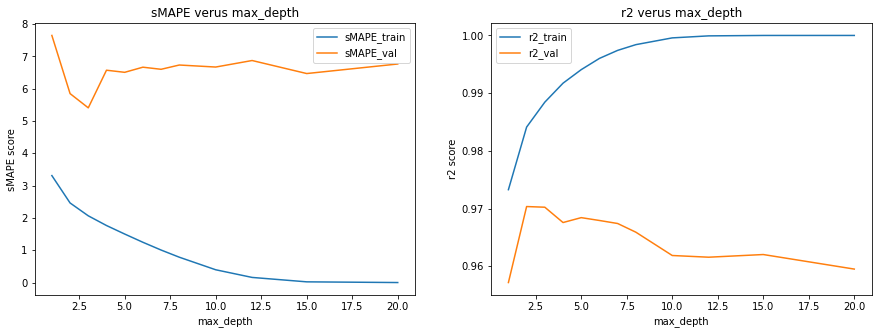

In [58]:
# Plot the results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(range_, sMAPE_train, label='sMAPE_train')
ax[0].plot(range_, sMAPE_val, label='sMAPE_val');
ax[0].set(xlabel='max_depth', ylabel='sMAPE score', title='sMAPE verus max_depth');
ax[0].legend();
ax[1].plot(range_, r2_train, label='r2_train');
ax[1].plot(range_, r2_val, label='r2_val');
ax[1].legend();
ax[1].set(xlabel='max_depth', ylabel='r2 score', title='r2 verus max_depth');


It actually appear that the model is overfitting starting at a max depth of three.  Let's run that model with `max_depth` set to three and add it to the results table.

In [10]:
# Instantiate and fit XGBRegressor
x2 = XGBRegressor(random_state=17, max_depth=3)
x2.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['xg2'] = compute_metrics(x2, (X_train, y_train), (X_val, y_val))
results_actual

,TSO_prediction,xg2
sMAPE_train,16.030,2.066642
sMAPE_val,16.922,5.409531
r2_train,0.954,0.988439
r2_val,0.971,0.970229


This model looks really good, without any other adjustments.  Lets look at the feature importances.

In [64]:
x2_importance = pd.DataFrame({'importance':x2.feature_importances_}, index=X_val.columns)
x2_importance.sort_values(by='importance',ascending=False, inplace=True)
x2_importance

,importance
price_day_ahead,0.815133
biomass_lag,0.022109
renewable_lag,0.022037
load_forecast,0.020702
generation_forecast,0.019582
coal_lag,0.018542
waste_lag,0.013883
transmission_fs_lag,0.006101
consumption_lag,0.004593
reservoir_lag,0.003799


Feature `price_day_ahead` is without a doubt the most important feature.  It would be good to investigate how our model would do without it.  Let's remove `'price_day_ahead` from the predictors and rerun the model.  I'll also reset `max_depth` to the default since this model may underfit without it's most informative feature.

In [67]:
# Drop 'price_day_ahead' from predictors
X_train.drop(columns='price_day_ahead', inplace=True)
X_val.drop(columns='price_day_ahead', inplace=True)

# Instantiate and fit XGBRegressor
x3 = XGBRegressor(random_state=17)
x3.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['xg3'] = compute_metrics(x3, (X_train, y_train), (X_val, y_val))
results_actual

,TSO_prediction,xg1,xg2,xg3
sMAPE_train,16.030,1.247603,2.066642,4.331078
sMAPE_val,16.922,6.668116,5.409531,27.240879
r2_train,0.954,0.996021,0.988439,0.952814
r2_val,0.971,0.967929,0.970229,0.427341


x3 performed substantially worse in sMAPE (+21.8) and in r2 (-0.55), without having `price_day_ahead`. While that makes sense, since `price_day_ahead` is the TSO prediction of tomorrow's price, let's see if we can tweak our model and get closer on our own.  The model is extremely overfitted on the training set.  Let's see if we can prune the tree starting with `max_depth` again.

complete max_depth
complete gamma
complete min_child_weight
complete subsample
complete colsample_bytree
complete reg_alpha
complete reg_lambda


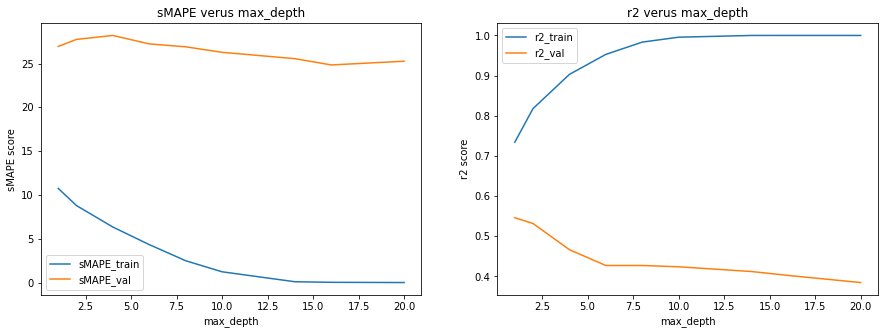

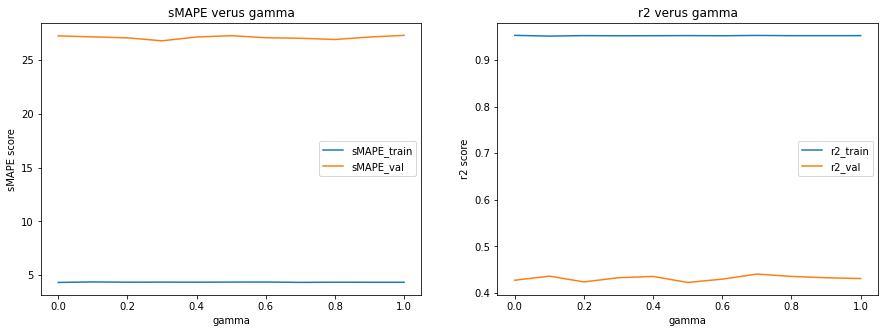

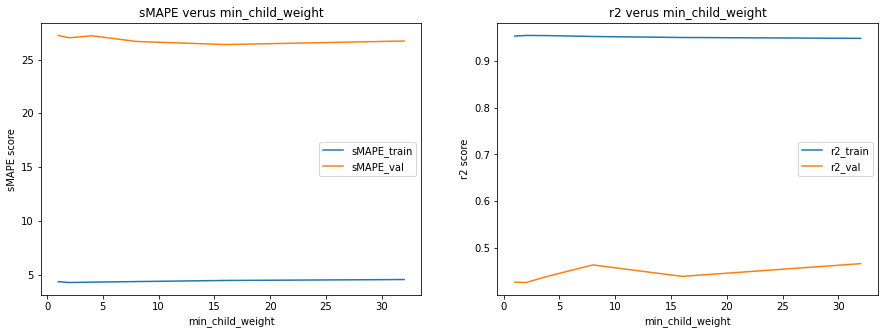

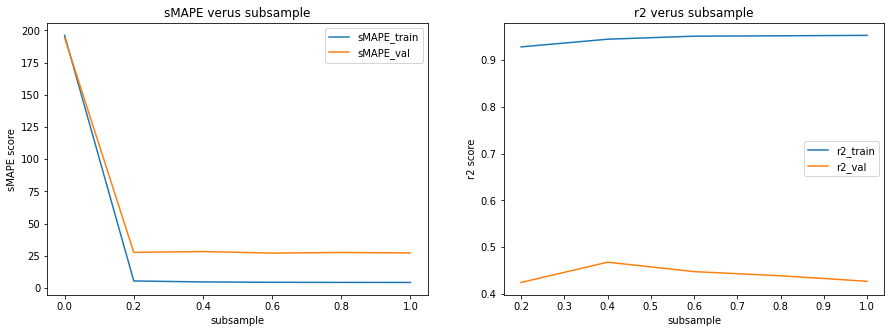

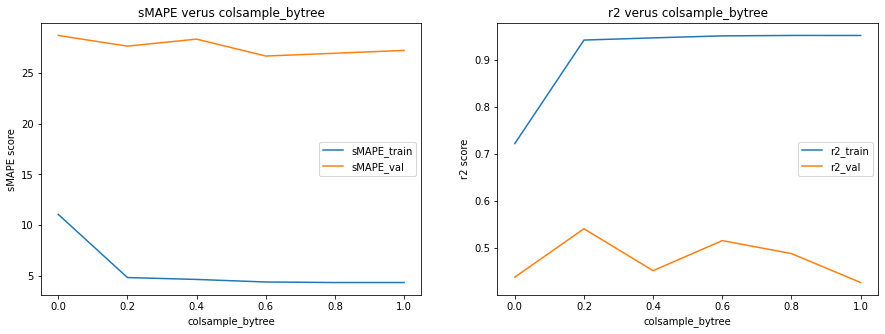

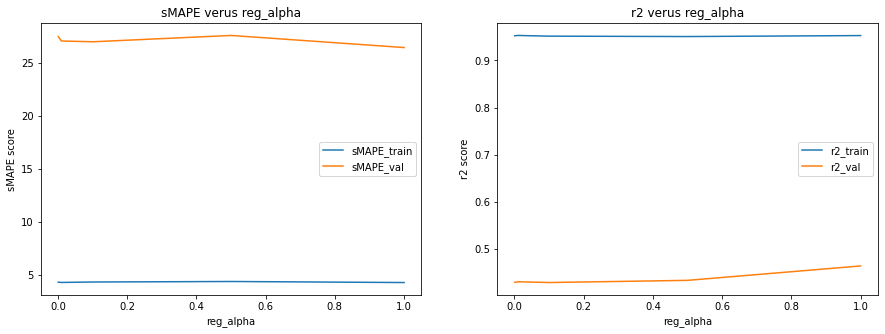

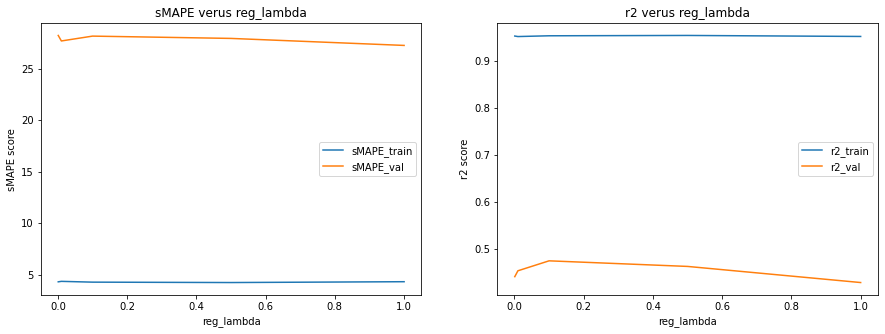

In [143]:
# Create dictionary to map param ranges to their parameters
xgb_params = {
    'max_depth': [1,2,4,6,8,10,14,16,20],
    'gamma': [n/10 for n in range(11)],
    'min_child_weight': [1,2,4,8,16,32],
    'subsample': [n/10 for n in range(0, 12, 2)],
    'colsample_bytree': [n/10 for n in range(0, 12, 2)],
    'reg_alpha': [.001, .01, .1, .5, 1],
    'reg_lambda': [.001, .01, .1, .5, 1]
}

# For each parameter and its respective range, plot the metrics
for param in xgb_params.keys():
    plot_metric_range(XGBRegressor, (X_train, y_train), (X_val, y_val), param, xgb_params[param])

Adjusting all of these parameters in their respective ranges, there really isn't much improvement in either of the metrics sMAPE nor r2. The one exception may be `max_depth` which did see minor improvements when increased to 16.  A depth of 16 is a pretty deep tree, and therefore is likely to overfit signficantly.  While regularization methods (`reg_alpha`, `reg_lambda`, and `gamma`, did not seem to help before, we'll still need to reduce overfitting.  That leaves us with the sub-sampling methods (`colsample_bytree`, `subsample`) to play with. Let's prune the tree with the these parameters and set `max_depth` to 16.

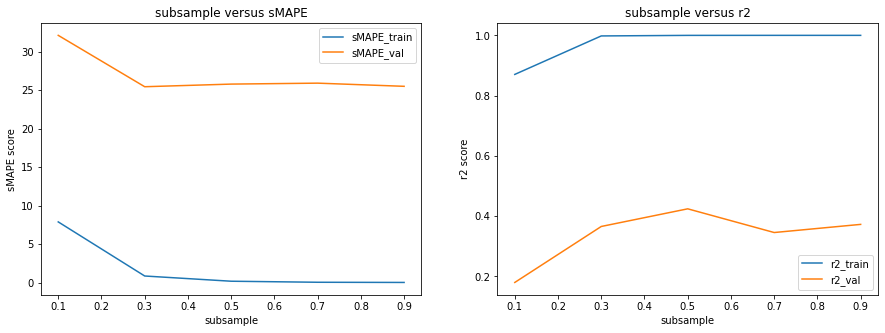

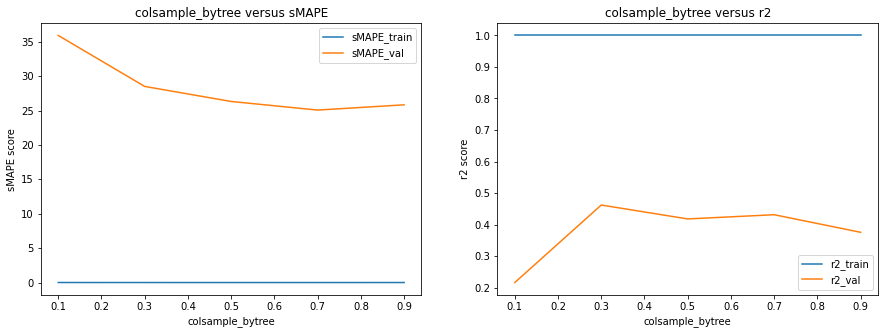

In [161]:
# Create dictionary to map param ranges to their parameters
xgb_params = {
    'subsample': [n/10 for n in range(1, 10, 2)],
    'colsample_bytree': [n/10 for n in range(1, 10, 2)],
}
# For each parameter and its respective range, plot the metrics
for param in xgb_params.keys():
    plot_metric_range(XGBRegressor(random_state=17, max_depth=16), (X_train, y_train),
                      (X_val, y_val), param, xgb_params[param])

Again, even after adjusting the ranges to explore more extreme parameter choices with deep trees, there's little to no improvement on sMAPE or r2.  Let's set each of `colsample_bytree` and `subsample` to 0.5, fit the model and add the results to the dataframe.

In [163]:
# Instantiate and fit XGBRegressor
x4 = XGBRegressor(random_state=17, max_depth=16, colsample_bytree=.5, subsample=.5)
x4.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['xg4'] = compute_metrics(x4, (X_train, y_train), (X_val, y_val))
results_actual

,TSO_prediction,xg1,xg2,xg3,xg4
sMAPE_train,16.030,1.247603,2.066642,4.331078,0.188545
sMAPE_val,16.922,6.668116,5.409531,27.240879,25.972180
r2_train,0.954,0.996021,0.988439,0.952814,0.999899
r2_val,0.971,0.967929,0.970229,0.427341,0.418582


Even after adjusting all the XGBoost pruning parameters, it appears the model does not improve and is grossly overfit.  Without `price_day_ahead` the features are having a really hard time predicting `price_actual`.

**Since `price_day_ahead` is significantly more important than any other feature in predicting actual price, are any of these other features helping much at all?**

### 4. Modeling Price Components (excluding `price_day_ahead`)
**Method 1**:<br>
To figure out if our predictors (excluding `price_day_ahead`) are helping predict the `price_actual`, let's model the residual of `price_actual` - `price_day_ahead`.  This residual represents the portion of `price_actual` not reflected in `price_day_ahead`. If we are able to model the residual, we could add the predictions from our model to `price_day_ahead` to improve our predictions for `price_actual`.

**Method 2**:<br>
Another method in modeling the components is to literally model each price component (besides `price_day_ahead`) individually. With predictions for each component by the hour, we could add up the price component predictions, along with `price_day_ahead` to come up with a final price.

### 4.1 Modeling price_actual residual
___
* Create price_residual
* Drop other price columns
* Split the data into training and validation data
___

In [13]:
# Get price cols to predict
price_cols = df_lag.filter(regex='price').columns.to_list()

# Create price_residual
data = df_lag.copy()
data['price_residual'] = data['price_day_ahead'] - data['price_actual']

# Drop other price cols, and split data
data.drop(columns = price_cols, inplace=True)
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_residual')

Now, we'll set up a results dataframe and run the first model.

In [14]:
# Create results table
results_resid = pd.DataFrame(index=['sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Instantiate and fit XGBRegressor
x_resid1 = XGBRegressor(random_state=17)
x_resid1.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_resid['x_resid1'] = compute_metrics(x_resid1, (X_train, y_train), (X_val, y_val))
results_resid

,x_resid1
sMAPE_train,9.025249
sMAPE_val,35.370161
r2_train,0.927338
r2_val,0.173706


As shown above, the model is very overfit on the training set.  Let's see if increasing/decreasing the max_depth will change increase/decrease the performance.

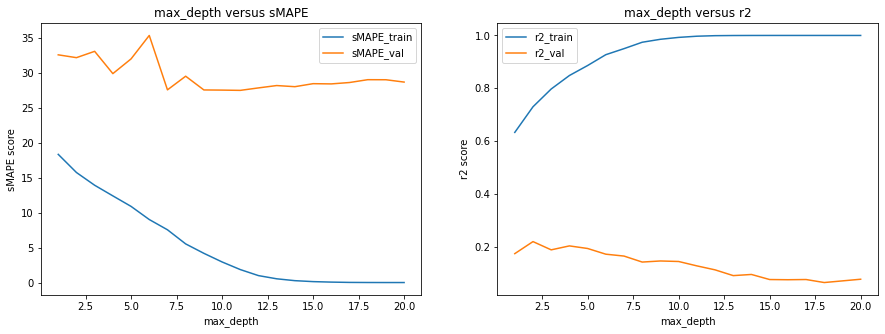

In [276]:
# Create dictionary to map param ranges to their parameters
xgb_params = {'max_depth': range(1,21,1)}

# For each parameter and its respective range, plot the metrics
for param in xgb_params.keys():
    plot_metric_range(XGBRegressor(random_state=17), (X_train, y_train),
                      (X_val, y_val), param, xgb_params[param])

Changing the tree depth only did decreased the testing sMAPE but it did not help with our overfitting issue.  Let's run through the same ranges of tree pruning/regularization techniques as before to see if we can appropriately fit the model.

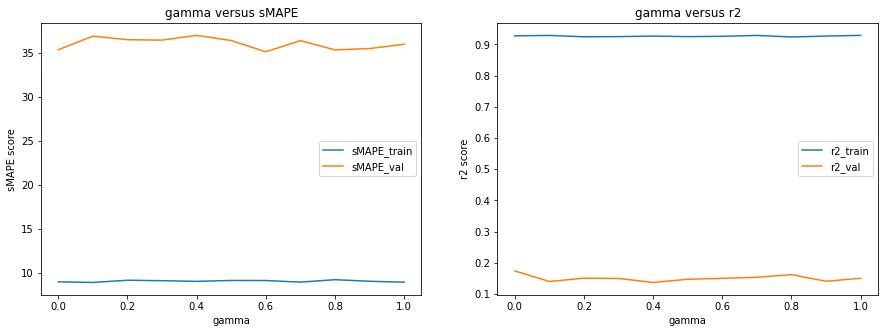

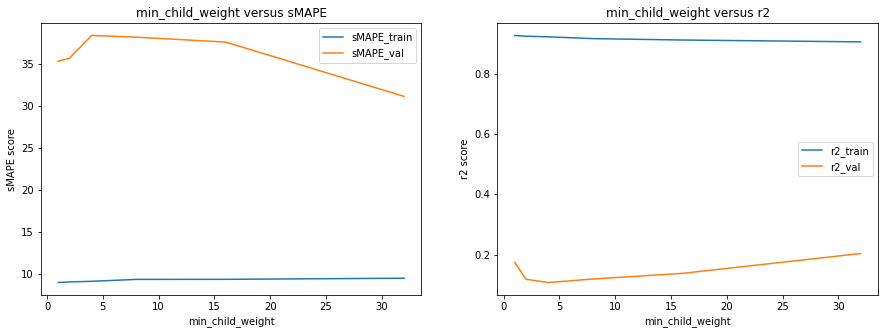

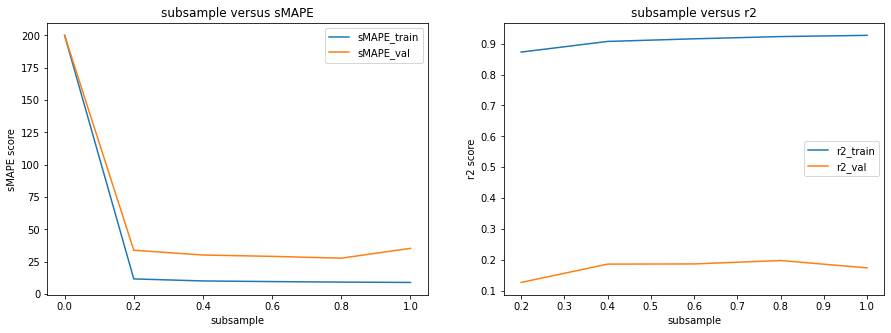

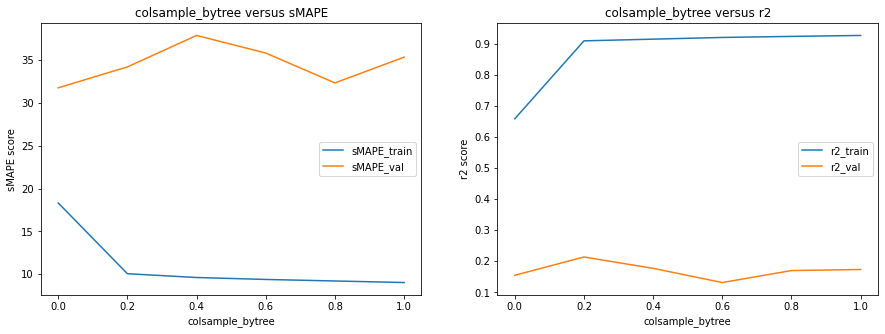

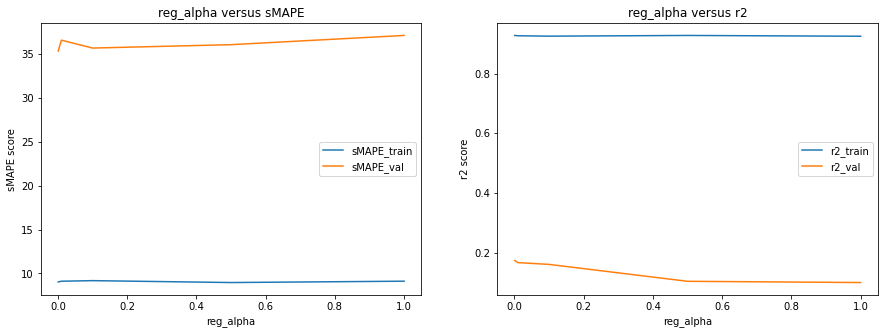

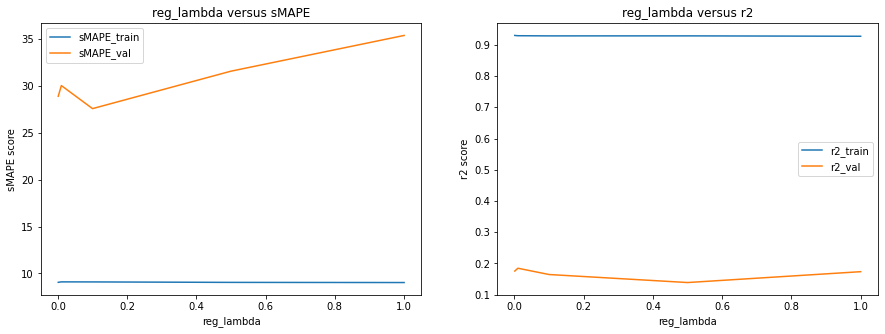

In [277]:
xgb_params = {
    'gamma': [n/10 for n in range(11)],
    'min_child_weight': [1,2,4,8,16,32],
    'subsample': [n/10 for n in range(0, 12, 2)],
    'colsample_bytree': [n/10 for n in range(0, 12, 2)],
    'reg_alpha': [.001, .01, .1, .5, 1],
    'reg_lambda': [.001, .01, .1, .5, 1]
}

# For each parameter and its respective range, plot the metrics
for param in xgb_params.keys():
    plot_metric_range(XGBRegressor(random_state=17), (X_train, y_train),
                      (X_val, y_val), param, xgb_params[param])

Looks like the model had an extremely hard time fitting on the residual.  Maybe the data really doesn't say anything about the combined components of price (minus `price_day_ahead`).

Let's move to the second option and see the data says anything about each component individually.  Here, I'll set up a model to predict each component. To begin, set up y_cols to include only the price components (exclude `price_day_ahead`).

In [31]:
# Get price cols to predict
price_cols = df_lag.filter(regex='price').columns.to_list()[1:]
price_cols.remove('price_day_ahead')

# Drop other price cols, and split data
data = df_lag.drop(columns=['price_day_ahead', 'price_actual'])
X_train, y_train, X_val, y_val = split_data(data, 2020, price_cols)

* `MultiOutputRegressor` which runs and stores a new model for each target
* Fit the new models for each target
* Run the predictions

In [32]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17)
x_multi = MultiOutputRegressor(xg_multi)

# Fit the Regressor
x_multi.fit(X_train, y_train);

# Get the predictions
preds_train = x_multi.predict(X_train)
preds_val = x_multi.predict(X_val)


To see the results, I'll set up a results_comp dataframe.  For each model in x_multi, I'll use the compute metric function to add the compute metrics to the table and output it below.

In [33]:
# Create results table
results_comp = pd.DataFrame(index=['sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Add metric results to results table
for i, model in enumerate(x_multi.estimators_):    
    results_comp[y_val.columns[i]] = compute_metrics(model,(X_train,y_train.iloc[:,i]), (X_val, y_val.iloc[:,i]))
results_comp.T.sort_values(by='sMAPE_val')

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,sMAPE_train,sMAPE_val,r2_train,r2_val
price_power_factor,2.435117,16.293799,0.970552,0.130353
price_capacity_payment,11.404629,38.368313,0.957103,0.573261
price_PBF_tech,22.812612,40.881838,0.933131,0.470719
price_sec_reserve,25.511023,58.703187,0.873666,0.297368
price_measured_imbalances,74.215783,94.996650,0.843589,0.001585
price_imbalances_net,107.657609,128.049893,0.655338,0.001148
price_balance_failure,127.367726,139.903382,0.646287,0.000866
price_intraday_market,115.229651,142.530756,0.675297,0.006006
price_P0146_balance,123.288978,148.703862,0.514304,0.001695
price_rt_tech,155.138772,172.340196,0.743252,0.016256


This table give a good look at how the model did by each component.  First to note, there are NaNs present in some of the r2 calculations.  The presence of NaNs and the warning above mean that we were dividing by zero at some point in the calcatulation - the relationship between the predictions and this particular component do not exist.  Second, while there is over-fitting going on for many of these components, it appears less over fit than when we had modeled the price residual.  We did actual obtain a decent sMAPE for `price_power_factor` components. Let's sort by r2 and see which components were best modeled with the data.

In [34]:
results_comp.T.sort_values(by='r2_val', ascending=False).head(4)

,sMAPE_train,sMAPE_val,r2_train,r2_val
price_capacity_payment,11.404629,38.368313,0.957103,0.573261
price_PBF_tech,22.812612,40.881838,0.933131,0.470719
price_sec_reserve,25.511023,58.703187,0.873666,0.297368
price_power_factor,2.435117,16.293799,0.970552,0.130353


The above shows the best r2 validation results by components. These components as expected also received the best sMAPE scores. The model may have some information pertaining to these individual components.  Just quickly, lets look at the feature importances for these components.

All the predictions are stored inside `preds_train`, and `preds_val`.  I'll extract these predictions with nested dictionaries then reformat them into dataframes for display

In [35]:
# Components to investigate: top 5 sMAPE components
top_modeled = results_comp.T.sort_values(by='sMAPE_val', ascending=False).head(4).index

# Get importance by component dict {x_cols:feature_importances}}
imp_by_comp = [
    dict(zip(X_val.columns, x_multi.estimators_[i].feature_importances_)) for i in range(len(x_multi.estimators_))
]

# Zip imp_by_comp into importance {y_components:{x_cols:feature_importances}}
importances = dict(zip(y_val.columns, imp_by_comp))

# Reformat into dataframe for viewing
x_multi_importances = pd.DataFrame(index = importances['price_intraday_tech'].keys(), columns= importances.keys())
for i in X_val.columns:
    for col in y_val.columns:
        x_multi_importances.loc[i, col] = importances[col][i]
x_multi_importances[top_modeled]

,price_intraday_tech,price_upward_reserve,price_generic_failure,price_interupt_service
temp_madrid_lag,0.0,0.016554,0.0,0.001013
dew_point_madrid_lag,0.0,0.006752,0.0,0.004061
humidities_madrid_lag,0.0,0.00907,0.0,0.004645
wind_madrid_lag,0.0,0.006899,0.0,0.000541
wind_speeds_madrid_lag,0.0,0.007161,0.0,0.001442
pressures_madrid_lag,0.0,0.069021,0.0,0.003836
condition_madrid_lag,0.0,0.006766,0.0,0.000891
temp_seville_lag,0.0,0.008864,0.0,0.003028
dew_point_seville_lag,0.0,0.009514,0.0,0.003237
humidities_seville_lag,0.0,0.040388,0.0,0.006486


In [36]:
# For each of the best_modeled components, print out any feature importance greater than .1
for col in top_modeled:
    important = x_multi_importances.loc[abs(x_multi_importances[col])>.1, col].sort_values(ascending=False)
    if len(important) > 0:
        print(col)
        for i in important.index:
            print(i+':', important[i])
        print()

price_intraday_tech
humidities_bilbao_lag: 0.55966157
poundage_lag: 0.43711734

price_interupt_service
coal_lag: 0.24452884
renewable_lag: 0.1263257



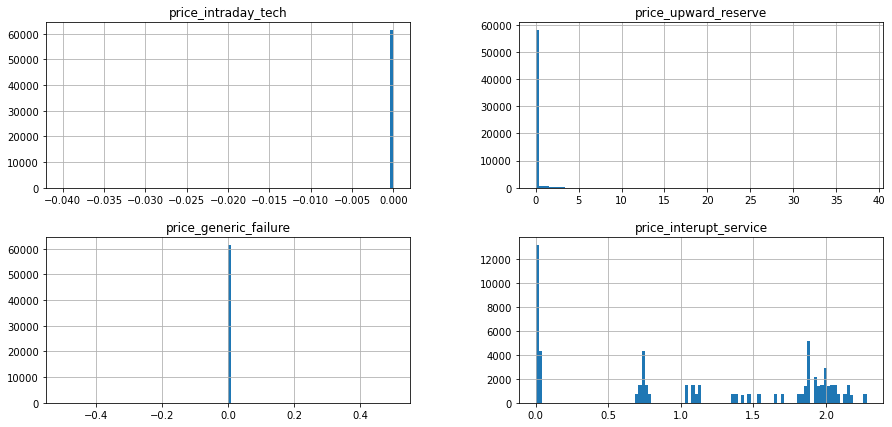

In [37]:
df_lag[top_modeled].hist(bins=100, figsize=(15,7));

In [330]:
print(df_lag.price_intraday_tech.value_counts(),'\n')
print(df_lag.price_generic_failure.value_counts())

 0.00    61342
-0.04        1
-0.02        1
Name: price_intraday_tech, dtype: int64 

0.0    61344
Name: price_generic_failure, dtype: int64


In [303]:
# Create results table
results_comp = pd.DataFrame(index=['sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Add metric results to results table
for i, model in enumerate(x_multi.estimators_):    
    results_comp[y_val.columns[i]] = compute_metrics(model,(X_train,y_train.iloc[:,i]), (X_val, y_val.iloc[:,i]))
results_comp

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,price_intraday_tech,price_PBF_tech,price_rt_tech,price_intraday_market,price_upward_reserve,price_sec_reserve,price_measured_imbalances,price_imbalances_net,price_capacity_payment,price_P0146_balance,price_generic_failure,price_interupt_service,price_power_factor,price_balance_failure
sMAPE_train,199.993807,22.812612,155.138772,115.229651,186.057323,25.511023,74.215783,107.657609,11.404629,123.288978,200.0,3.722258,2.435117,127.367726
sMAPE_val,200.000000,40.881838,172.340196,142.530756,200.000000,58.703187,94.996650,128.049893,38.368313,148.703862,200.0,191.344004,16.293799,139.903382
r2_train,0.953816,0.933131,0.743252,0.675297,0.874523,0.873666,0.843589,0.655338,0.957103,0.514304,NaN,0.980549,0.970552,0.646287
r2_val,NaN,0.470719,0.016256,0.006006,NaN,0.297368,0.001585,0.001148,0.573261,0.001695,NaN,0.037187,0.130353,0.000866


Multiple Regression 1

In [30]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17, max_depth=2)
x_multi1 = MultiOutputRegressor(xg_multi)

# Fit the Regressor
x_multi1.fit(X_train, y_train);

# Get the predictions
preds_train = x_multi1.predict(X_train)
preds_val = x_multi1.predict(X_val)


ValueError: y must have at least two dimensions for multi-output regression but has only one.

In [334]:
# Create results table
results_comp1 = pd.DataFrame(index=['sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Add metric results to results table
for i, model in enumerate(x_multi1.estimators_):    
    results_comp1[y_val.columns[i]] = compute_metrics(model,(X_train,y_train.iloc[:,i]), (X_val, y_val.iloc[:,i]))
results_comp1.T.sort_values(by='sMAPE_val')

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,sMAPE_train,sMAPE_val,r2_train,r2_val
price_power_factor,6.700780,15.862538,0.789041,0.099092
price_capacity_payment,21.522748,34.082316,0.820507,0.622816
price_PBF_tech,35.892300,37.339667,0.753944,0.515766
price_sec_reserve,37.251264,55.285333,0.606012,0.350260
price_measured_imbalances,87.039122,89.122873,0.296958,0.005052
price_imbalances_net,119.298528,130.359348,0.222973,0.001856
price_balance_failure,133.106132,132.051015,0.138574,0.002832
price_intraday_market,146.932837,136.017101,0.164858,0.012682
price_P0146_balance,157.443982,155.815424,0.100147,0.001843
price_rt_tech,160.538466,175.743797,0.216522,0.010128


### Final Model Composition

In [358]:
y_train.shape
y_val.shape



(8784, 14)

In [11]:
# Results 
xg_results = pd.DataFrame(index=['sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])
xg_results['TSO_prediction'] = [round(sMAPE(y_train, df_lag.loc[:'2019', 'price_day_ahead']), 3),
                                round(sMAPE(y_val, df_lag.loc['2020', 'price_day_ahead']), 3),
                                round(r2(y_train, df_lag.loc[:'2019', 'price_day_ahead']), 3), 
                                round(r2(y_val, df_lag.loc['2020', 'price_day_ahead']),3)]
xg_results

,TSO_prediction
sMAPE_train,16.030
sMAPE_val,16.922
r2_train,0.954
r2_val,0.971


In [12]:
# Get price cols to remove
price_cols = df_lag.filter(regex='price').columns.to_list()[1:]
price_cols.remove('price_day_ahead')

# Create dataset without price cols to remove, split data
data = df_lag.drop(columns=price_cols)
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_actual')

xg_results['xg2'] = compute_metrics(x2, (X_train, y_train), (X_val, y_val))

In [15]:
# Get price cols to predict
price_cols = df_lag.filter(regex='price').columns.to_list()

# Create price_residual
data = df_lag.copy()
data['price_residual'] = data['price_day_ahead'] - data['price_actual']

# Drop other price cols, and split data
data.drop(columns = price_cols, inplace=True)
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_residual')

,TSO_prediction,xg2,x_resid1
sMAPE_train,16.030,2.066642,9.025249
sMAPE_val,16.922,5.409531,35.370161
r2_train,0.954,0.988439,0.927338
r2_val,0.971,0.970229,0.173706


In [17]:
x_resid1_preds_train = x_resid1.predict(X_train) + df_lag.loc[:'2019', 'price_day_ahead']
x_resid1_preds_val = x_resid1.predict(X_val) + df_lag.loc['2020', 'price_day_ahead']

In [46]:
x_resid1_sMAPE_train = sMAPE(df_lag.loc[:'2019', 'price_actual'], x_resid1_preds_train)
x_resid1_sMAPE_test = sMAPE(df_lag.loc['2020', 'price_actual'], x_resid1_preds_val)
x_resid1_r2_train = r2(df_lag.loc[:'2019', 'price_actual'], x_resid1_preds_train)
x_resid1_r2_test = r2(df_lag.loc['2020', 'price_actual'], x_resid1_preds_val)

xg_results['xg_resid1'] = [x_resid1_sMAPE_train, x_resid1_sMAPE_test, x_resid1_r2_train,x_resid1_r2_test]

In [51]:
# multiple regression
# Get price cols to predict
price_cols = df_lag.filter(regex='price').columns.to_list()[1:]
price_cols.remove('price_day_ahead')

# Drop other price cols, and split data
data = df_lag.drop(columns=['price_day_ahead', 'price_actual'])
X_train, y_train, X_val, y_val = split_data(data, 2020, price_cols)

x_multi_preds_train = x_multi.predict(X_train).sum(axis=1) + df_lag.loc[:'2019', 'price_day_ahead']
x_multi_preds_val = x_multi.predict(X_val).sum(axis=1) + df_lag.loc['2020', 'price_day_ahead']

x_multi_sMAPE_train = sMAPE(df_lag.loc[:'2019', 'price_actual'], x_multi_preds_train)
x_multi_sMAPE_test = sMAPE(df_lag.loc['2020', 'price_actual'], x_multi_preds_val)
x_multi_r2_train = r2(df_lag.loc[:'2019', 'price_actual'], x_multi_preds_train)
x_multi_r2_test = r2(df_lag.loc['2020', 'price_actual'], x_multi_preds_val)

xg_results['xg_multi'] = [x_multi_sMAPE_train, x_multi_sMAPE_test, x_multi_r2_train,x_multi_r2_test]

In [52]:
xg_results

,TSO_prediction,xg2,xg_resid1,xg_multi
sMAPE_train,16.030,2.066642,35.419904,1.026609
sMAPE_val,16.922,5.409531,43.575567,6.070960
r2_train,0.954,0.988439,0.847609,0.997337
r2_val,0.971,0.970229,0.932794,0.969791


KeyboardInterrupt: 

In [ ]:
xg_results

In [40]:
df_lag.loc[:'2019', 'price_actual']

2015-01-02 00:00:00    64.02
2015-01-02 01:00:00    58.46
2015-01-02 02:00:00    54.70
2015-01-02 03:00:00    54.91
2015-01-02 04:00:00    53.07
                       ...  
2019-12-31 19:00:00    54.08
2019-12-31 20:00:00    49.67
2019-12-31 21:00:00    46.23
2019-12-31 22:00:00    43.97
2019-12-31 23:00:00    42.44
Name: price_actual, Length: 43800, dtype: float64

In [241]:
sMAPE(y_train['price_intraday_tech'], preds_train[:,0])

199.99380717728135

In [247]:
def compute_metrics(model, train, test):
    # Get the train and test predictions
    preds_train = model.predict(train[0])
    preds_test = model.predict(test[0])
    
    # If the output is multivariate, sum the predictions and true values
    if len(train[1].shape)>1:
        sMAPE_train, r2_train, sMAPE_test, r2_test = [], [], [], []
        for i, col in enumerate(train[1].columns):
            sMAPE_train.append(sMAPE(train[1][col], preds_train[:,i]))
            sMAPE_test.append(sMAPE(test[1][col], preds_test[:,i]))
            r2_train.append(r2(train[1][col], preds_train[:,i]))
            r2_test.append(r2(test[1][col], preds_test[:,i]))

        # average the metrics
        sMAPE_train = np.mean(sMAPE_train)
        sMAPE_test = np.mean(sMAPE_test)
        r2_train = np.mean(r2_train)
        r2_test = np.mean(r2_test)

    else:
        sMAPE_train = sMAPE(train[1], preds_train)
        sMAPE_test = sMAPE(test[1], preds_test)

        r2_train = r2(train[1], preds_train)
        r2_test = r2(test[1], preds_test)
    
    return [sMAPE_train, sMAPE_test, r2_train, r2_test]

In [180]:
r2

""
sMAPE_train
sMAPE_val
r2_train
r2_val


In [266]:
np.corrcoef(y_val.iloc[:,0], x_comp0.predict(X_val)[:,0])

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[nan, nan],
       [nan,  1.]])

In [265]:
y_val.iloc[:,0]

2020-01-01 00:00:00    0.0
2020-01-01 01:00:00    0.0
2020-01-01 02:00:00    0.0
2020-01-01 03:00:00    0.0
2020-01-01 04:00:00    0.0
                      ... 
2020-12-31 19:00:00    0.0
2020-12-31 20:00:00    0.0
2020-12-31 21:00:00    0.0
2020-12-31 22:00:00    0.0
2020-12-31 23:00:00    0.0
Name: price_intraday_tech, Length: 8784, dtype: float64

In [263]:
x_comp0.predict(X_val)[:,0]

array([-5.7070594e-07, -5.7070594e-07, -5.7070594e-07, ...,
       -5.7070594e-07, -5.7070594e-07, -5.7070594e-07], dtype=float32)

In [258]:
r2(y_val.iloc[:,0],x_comp0.predict(X_val)[:,0])

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan

In [248]:
results_components = pd.DataFrame(index=['sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Instantiate XGBRegressor and Multioutput Regressor
#x_multi = XGBRegressor(random_state=17)
#x_comp0 = MultiOutputRegressor(x_multi)

# Fit the Regressor
#x_comp0.fit(X_train, y_train)

# Compute metrics and add the results
results_components['x_comp0'] = compute_metrics(x_comp0, (X_train, y_train), (X_val, y_val))
results_components

14
14
[0.9538163730457018, 0.9331313465041501, 0.7432516371313569, 0.6752968363164379, 0.8745229660436251, 0.8736660958114912, 0.8435888130233693, 0.6553384538882041, 0.9571028409540464, 0.5143044431112381, nan, 0.9805488420692672, 0.9705520398550049, 0.6462868904564901]
[nan, 0.4707189508611541, 0.01625623954063286, 0.0060057617511377085, nan, 0.2973675903976232, 0.0015854256117649982, 0.001147659715108763, 0.573261136955946, 0.0016954126501033085, nan, 0.0371871244531052, 0.13035317128656557, 0.0008663345350315668]
96.7739491592566
126.57970579443021
nan
nan


C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,x_comp0
sMAPE_train,96.773949
sMAPE_val,126.579706
r2_train,NaN
r2_val,NaN


### Multivariate - Predict All Price Components
* Predictors - weather_lag, transmission_lag, gen_lag, load_forecast, load_actual, solar_forecast_lag, wind_forecast_lag, generation_forecast, consumption_forecast
* Targets: all price components (not including final `price_actual`)


In [193]:
# Split Data
price_cols = df_lag.filter(regex='price').columns.to_list()
price_cols.remove('price_actual')
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns='price_actual'), 2020, price_cols)

In [30]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17)
xg5 = MultiOutputRegressor(xg_multi)

# Fit the Regressor
xg5.fit(X_train, y_train)

# Compute metrics and add the results
results = compute_metrics(xg5,5, X_train, y_train, X_val, y_val, results)

In [31]:
results

,sMAPE_train,sMAPE_val,r2_train,r2_val
0,NaN,16.922000,NaN,0.971000
1,1.247603,6.668116,0.996021,0.967929
2,2.066642,5.409531,0.988439,0.970229
3,4.331078,27.240879,0.952814,0.427341
4,10.747146,26.949521,0.734180,0.546224
5,4.276335,29.188466,0.954023,0.490948


In [198]:
imp_by_comp = [dict(zip(X_val.columns, xg5.estimators_[i].feature_importances_)) for i in range(len(xg5.estimators_))]
importances = dict(zip(y_val.columns, imp_by_comp))

xg5_importances = pd.DataFrame(index = importances['price_intraday_tech'].keys(), columns= importances.keys())
for i in X_val.columns:
    for col in y_val.columns:
        xg5_importances.loc[i, col] = importances[col][i]

In [208]:
day_ahead_true = y_val.loc[:,'price_day_ahead'].copy()

In [207]:
day_ahead_preds = xg5.predict(X_val)[:,4]

In [210]:
np.corrcoef(day_ahead_true, day_ahead_preds)[0][1]**2

0.46628412892323834

In [211]:
sMAPE(day_ahead_true, day_ahead_preds)

31.572035072062864

In [213]:
xg5_importances['price_day_ahead'].sort_values(ascending=False)

consumption_forecast         0.343385
coal/lignite_lag             0.095619
coal_lag                     0.067578
transmission_sf_lag           0.05264
renewable_lag                0.035457
wind_forecast                0.030311
load_forecast                0.025348
reservoir_lag                0.024574
gas_lag                      0.021951
load_actual                  0.020799
poundage_lag                 0.018772
waste_lag                    0.018711
nuclear_lag                  0.016632
transmission_fs_lag           0.01554
temp_valencia_lag             0.01448
other_lag                    0.014354
temp_barcelona_lag           0.010418
generation_forecast          0.010159
humidities_madrid_lag        0.009966
solar_lag                    0.009931
oil_lag                      0.009634
pressures_seville_lag        0.009213
solar_forecast               0.008884
temp_seville_lag             0.008223
dew_point_barcelona_lag       0.00804
biomass_lag                  0.007338
condition_bi

### Multivariate - Predict Components Except `price_day_ahead`, sum with `price_day_ahead` for final price
* Predictors - weather_lag, transmission_lag, gen_lag, load_forecast, load_actual, solar_forecast_lag, wind_forecast_lag, generation_forecast, consumption_forecast
* Targets: all price components (not including final `price_day_ahead` and `price_actual`)


In [181]:
# Split Data
price_cols = df_lag.filter(regex='price').columns.to_list()
price_cols.remove('price_actual')
price_cols.remove('price_day_ahead')
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=['price_actual', 'price_day_ahead']), 2020, price_cols)

In [182]:
X_train.columns

Index(['temp_madrid_lag', 'dew_point_madrid_lag', 'humidities_madrid_lag',
       'wind_madrid_lag', 'wind_speeds_madrid_lag', 'pressures_madrid_lag',
       'condition_madrid_lag', 'temp_seville_lag', 'dew_point_seville_lag',
       'humidities_seville_lag', 'wind_seville_lag', 'wind_speeds_seville_lag',
       'pressures_seville_lag', 'condition_seville_lag', 'temp_barcelona_lag',
       'dew_point_barcelona_lag', 'humidities_barcelona_lag',
       'wind_barcelona_lag', 'wind_speeds_barcelona_lag',
       'pressures_barcelona_lag', 'condition_barcelona_lag', 'temp_bilbao_lag',
       'dew_point_bilbao_lag', 'humidities_bilbao_lag', 'wind_bilbao_lag',
       'wind_speeds_bilbao_lag', 'pressures_bilbao_lag',
       'condition_bilbao_lag', 'temp_valencia_lag', 'dew_point_valencia_lag',
       'humidities_valencia_lag', 'wind_valencia_lag',
       'wind_speeds_valencia_lag', 'pressures_valencia_lag',
       'condition_valencia_lag', 'transmission_ps_lag', 'transmission_sp_lag',
       't

In [183]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17, max_depth=2)
xg6 = MultiOutputRegressor(xg_multi)

# Fit the Regressor
xg6.fit(X_train, y_train)

# Get price_day_ahead for 2020
price_day_ahead_2020 = df_lag.loc['2020', 'price_day_ahead'].copy()
price_day_ahead_2020_train = df_lag.loc[:'2019', 'price_day_ahead'].copy()

# Get price component predictions 2020
xg6_pred_components_sum = xg6.predict(X_val).sum(axis=1)
xg6_train_components_sum = xg6.predict(X_train).sum(axis=1)

# Add the price component predictions to the price_day_ahead
xg6_preds = price_day_ahead_2020.add(xg6_pred_components_sum)
xg6_preds_train = price_day_ahead_2020_train.add(xg6_train_components_sum)

# Get the true values for price actual
xg6_true = df_lag.loc['2020', 'price_actual'].copy()
xg6_true_train = df_lag.loc[:'2019', 'price_actual'].copy()

# r2
print('r2:', np.corrcoef(xg6_preds, xg6_true)[0][1]**2)
print('r2_train:', np.corrcoef(xg6_preds_train, xg6_true_train)[0][1]**2)

# sMAPE
print('sMAPE:', sMAPE(xg6_true, xg6_preds))
print('sMAPE_train:', sMAPE(xg6_true_train, xg6_preds_train))

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=2,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=17, reg_alpha=None,
                                           

In [184]:
# Get price_day_ahead for 2020
price_day_ahead_2020 = df_lag.loc['2020', 'price_day_ahead'].copy()
price_day_ahead_2020_train = df_lag.loc[:'2019', 'price_day_ahead'].copy()

# Get price component predictions 2020
xg6_pred_components_sum = xg6.predict(X_val).sum(axis=1)
xg6_train_components_sum = xg6.predict(X_train).sum(axis=1)

# Add the price component predictions to the price_day_ahead
xg6_preds = price_day_ahead_2020.add(xg6_pred_components_sum)
xg6_preds_train = price_day_ahead_2020_train.add(xg6_train_components_sum)

# Get the true values for price actual
xg6_true = df_lag.loc['2020', 'price_actual'].copy()
xg6_true_train = df_lag.loc[:'2019', 'price_actual'].copy()

# r2
print('r2:', np.corrcoef(xg6_preds, xg6_true)[0][1]**2)
print('r2_train:', np.corrcoef(xg6_preds_train, xg6_true_train)[0][1]**2)

# sMAPE
print('sMAPE:', sMAPE(xg6_true, xg6_preds))
print('sMAPE_train:', sMAPE(xg6_true_train, xg6_preds_train))

r2: 0.9748491321716013
r2_train: 0.9883568929420955
sMAPE: 4.934484132010065
sMAPE_train: 2.0884740922537786


In [192]:
results

,sMAPE_train,sMAPE_val,r2_train,r2_val
0,NaN,16.922000,NaN,0.971000
1,1.247603,6.668116,0.996021,0.967929
2,2.066642,5.409531,0.988439,0.970229
3,4.331078,27.240879,0.952814,0.427341
4,10.747146,26.949521,0.734180,0.546224
5,4.276335,29.188466,0.954023,0.490948
6,7.830178,41.053457,0.947377,0.272628


In [60]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17, max_depth=3)
xg6 = MultiOutputRegressor(xg_multi)

# Fit the Regressor
xg6.fit(X_train, y_train)

# Get price_day_ahead for 2020
price_day_ahead_2020 = df_lag.loc['2020', 'price_day_ahead'].copy()
price_day_ahead_2020_train = df_lag.loc[:'2019', 'price_day_ahead'].copy()

# Get price component predictions 2020
xg6_pred_components_sum = xg6.predict(X_val).sum(axis=1)
xg6_train_components_sum = xg6.predict(X_train).sum(axis=1)

# Add the price component predictions to the price_day_ahead
xg6_preds = price_day_ahead_2020.add(xg6_pred_components_sum)
xg6_preds_train = price_day_ahead_2020_train.add(xg6_train_components_sum)

# Get the true values for price actual
xg6_true = df_lag.loc['2020', 'price_actual'].copy()
xg6_true_train = df_lag.loc[:'2019', 'price_actual'].copy()

# r2
print('r2:', np.corrcoef(xg6_preds, xg6_true)[0][1]**2)
print('r2_train:', np.corrcoef(xg6_preds_train, xg6_true_train)[0][1]**2)

# sMAPE
print('sMAPE:', sMAPE(xg6_true, xg6_preds))
print('sMAPE_train:', sMAPE(xg6_true_train, xg6_preds_train))

r2: 0.9723055333114159
r2_train: 0.9920659291844338
sMAPE: 5.722115111280532
sMAPE_train: 1.738334293936403


In [61]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17, max_depth=4)
xg6 = MultiOutputRegressor(xg_multi)

# Fit the Regressor
xg6.fit(X_train, y_train)

# Get price_day_ahead for 2020
price_day_ahead_2020 = df_lag.loc['2020', 'price_day_ahead'].copy()
price_day_ahead_2020_train = df_lag.loc[:'2019', 'price_day_ahead'].copy()

# Get price component predictions 2020
xg6_pred_components_sum = xg6.predict(X_val).sum(axis=1)
xg6_train_components_sum = xg6.predict(X_train).sum(axis=1)

# Add the price component predictions to the price_day_ahead
xg6_preds = price_day_ahead_2020.add(xg6_pred_components_sum)
xg6_preds_train = price_day_ahead_2020_train.add(xg6_train_components_sum)

# Get the true values for price actual
xg6_true = df_lag.loc['2020', 'price_actual'].copy()
xg6_true_train = df_lag.loc[:'2019', 'price_actual'].copy()

# r2
print('r2:', np.corrcoef(xg6_preds, xg6_true)[0][1]**2)
print('r2_train:', np.corrcoef(xg6_preds_train, xg6_true_train)[0][1]**2)

# sMAPE
print('sMAPE:', sMAPE(xg6_true, xg6_preds))
print('sMAPE_train:', sMAPE(xg6_true_train, xg6_preds_train))

r2: 0.9745202972671848
r2_train: 0.9945612237520426
sMAPE: 5.6614821916687585
sMAPE_train: 1.4576393336859501


In [62]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17, max_depth=5)
xg6 = MultiOutputRegressor(xg_multi)

# Fit the Regressor
xg6.fit(X_train, y_train)

# Get price_day_ahead for 2020
price_day_ahead_2020 = df_lag.loc['2020', 'price_day_ahead'].copy()
price_day_ahead_2020_train = df_lag.loc[:'2019', 'price_day_ahead'].copy()

# Get price component predictions 2020
xg6_pred_components_sum = xg6.predict(X_val).sum(axis=1)
xg6_train_components_sum = xg6.predict(X_train).sum(axis=1)

# Add the price component predictions to the price_day_ahead
xg6_preds = price_day_ahead_2020.add(xg6_pred_components_sum)
xg6_preds_train = price_day_ahead_2020_train.add(xg6_train_components_sum)

# Get the true values for price actual
xg6_true = df_lag.loc['2020', 'price_actual'].copy()
xg6_true_train = df_lag.loc[:'2019', 'price_actual'].copy()

# r2
print('r2:', np.corrcoef(xg6_preds, xg6_true)[0][1]**2)
print('r2_train:', np.corrcoef(xg6_preds_train, xg6_true_train)[0][1]**2)

# sMAPE
print('sMAPE:', sMAPE(xg6_true, xg6_preds))
print('sMAPE_train:', sMAPE(xg6_true_train, xg6_preds_train))

r2: 0.9719567266970136
r2_train: 0.9962161860606971
sMAPE: 6.228484845496686
sMAPE_train: 1.2167791310501221


In [225]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17, max_depth=2)
xg6 = MultiOutputRegressor(xg_multi)

# Fit the Regressor
xg6.fit(X_train, y_train)

# Get price_day_ahead for 2020
price_day_ahead_2020 = df_lag.loc['2020', 'price_day_ahead'].copy()
price_day_ahead_2020_train = df_lag.loc[:'2019', 'price_day_ahead'].copy()

# Get price component predictions 2020
xg6_pred_components_sum = xg6.predict(X_val).sum(axis=1)
xg6_train_components_sum = xg6.predict(X_train).sum(axis=1)

# Add the price component predictions to the price_day_ahead
xg6_preds = price_day_ahead_2020.add(xg6_pred_components_sum)
xg6_preds_train = price_day_ahead_2020_train.add(xg6_train_components_sum)

# Get the true values for price actual
xg6_true = df_lag.loc['2020', 'price_actual'].copy()
xg6_true_train = df_lag.loc[:'2019', 'price_actual'].copy()

# r2
print('r2:', np.corrcoef(xg6_preds, xg6_true)[0][1]**2)
print('r2_train:', np.corrcoef(xg6_preds_train, xg6_true_train)[0][1]**2)

# sMAPE
print('sMAPE:', sMAPE(xg6_true, xg6_preds))
print('sMAPE_train:', sMAPE(xg6_true_train, xg6_preds_train))

r2: 0.8708635071720322
r2_train: 0.9404611148496063
sMAPE: 74.47670800009857
sMAPE_train: 60.52741474707866


In [226]:
imp_by_comp = [dict(zip(X_val.columns, xg6.estimators_[i].feature_importances_)) for i in range(len(xg6.estimators_))]
importances = dict(zip(y_val.columns, imp_by_comp))

In [227]:
xg6_importances = pd.DataFrame(index = importances.keys(), columns=importances['price_intraday_tech'].keys())
for i in xg6_importances.index:
    for col in importances[i].keys():
        xg6_importances.loc[i, col] = importances[i][col]

In [228]:
xg6_importances

,temp_madrid_lag,dew_point_madrid_lag,humidities_madrid_lag,wind_madrid_lag,wind_speeds_madrid_lag,pressures_madrid_lag,condition_madrid_lag,temp_seville_lag,dew_point_seville_lag,humidities_seville_lag,...,renewable_lag,solar_lag,waste_lag,onshore_lag,load_forecast,load_actual,solar_forecast,wind_forecast,generation_forecast,consumption_forecast
price_intraday_tech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
price_PBF_tech,0.002802,0.0,0.004038,0.001916,0.002097,0.003247,0.0,0.011215,0.005214,0.0,...,0.199577,0.013439,0.068132,0.001781,0.186662,0.051406,0.003121,0.008865,0.007318,0.142586
price_rt_tech,0.023376,0.037954,0.00642,0.0,0.005319,0.006761,0.004277,0.002845,0.025196,0.007448,...,0.094354,0.02106,0.030566,0.007324,0.023286,0.039785,0.011212,0.009654,0.017571,0.015611
price_intraday_market,0.0101,0.026676,0.048492,0.0,0.0,0.024627,0.031756,0.009397,0.032254,0.008815,...,0.038624,0.031777,0.031558,0.008877,0.018359,0.0,0.018296,0.011435,0.033739,0.027439
price_day_ahead,0.043403,0.007007,0.013121,0.0,0.0,0.005221,0.0,0.0,0.0,0.006641,...,0.049816,0.01264,0.0241,0.007565,0.018905,0.020024,0.006611,0.026796,0.02802,0.212905
price_upward_reserve,0.016544,0.007028,0.027892,0.005871,0.0,0.0,0.0,0.004584,0.008735,0.02301,...,0.012136,0.03407,0.013336,0.023127,0.054435,0.008365,0.04674,0.045551,0.013073,0.089143
price_sec_reserve,0.002861,0.0,0.002001,0.0,0.002703,0.00317,0.0,0.017972,0.005576,0.001612,...,0.13949,0.014613,0.049449,0.012456,0.031681,0.051338,0.034159,0.063237,0.005556,0.194763
price_measured_imbalances,0.006345,0.021937,0.008989,0.0,0.018919,0.011404,0.002245,0.006584,0.011008,0.01804,...,0.018911,0.010136,0.008153,0.026549,0.012567,0.0105,0.034914,0.031223,0.134063,0.021504
price_imbalances_net,0.012055,0.045312,0.001453,0.004767,0.04736,0.034082,0.003734,0.032814,0.019033,0.0,...,0.029988,0.02227,0.014271,0.04927,0.030751,0.010558,0.018456,0.01575,0.015241,0.028373
price_capacity_payment,0.008432,0.0,0.0,0.0,0.0,0.015459,0.0,0.012545,0.001871,0.003089,...,0.029299,0.017158,0.044904,0.0021,0.278364,0.007051,0.10037,0.002931,0.074463,0.048579


In [229]:
xg6_importances = pd.DataFrame(index = importances['price_intraday_tech'].keys(), columns= importances.keys())
for i in X_val.columns:
    for col in y_val.columns:
        xg6_importances.loc[i, col] = importances[col][i]

In [230]:
xg6_importances

,price_intraday_tech,price_PBF_tech,price_rt_tech,price_intraday_market,price_day_ahead,price_upward_reserve,price_sec_reserve,price_measured_imbalances,price_imbalances_net,price_capacity_payment,price_P0146_balance,price_generic_failure,price_interupt_service,price_power_factor,price_balance_failure
temp_madrid_lag,0.0,0.002802,0.023376,0.0101,0.043403,0.016544,0.002861,0.006345,0.012055,0.008432,0.016475,0.0,0.005936,0.000174,0.006023
dew_point_madrid_lag,0.0,0.0,0.037954,0.026676,0.007007,0.007028,0.0,0.021937,0.045312,0.0,0.02378,0.0,0.022598,0.004005,0.00523
humidities_madrid_lag,0.0,0.004038,0.00642,0.048492,0.013121,0.027892,0.002001,0.008989,0.001453,0.0,0.011579,0.0,0.005836,0.00355,0.015383
wind_madrid_lag,0.0,0.001916,0.0,0.0,0.0,0.005871,0.0,0.0,0.004767,0.0,0.0,0.0,0.00244,0.005592,0.0
wind_speeds_madrid_lag,0.0,0.002097,0.005319,0.0,0.0,0.0,0.002703,0.018919,0.04736,0.0,0.050112,0.0,0.0,0.0,0.0
pressures_madrid_lag,0.0,0.003247,0.006761,0.024627,0.005221,0.0,0.00317,0.011404,0.034082,0.015459,0.020887,0.0,0.00698,0.005127,0.010878
condition_madrid_lag,0.0,0.0,0.004277,0.031756,0.0,0.0,0.0,0.002245,0.003734,0.0,0.0,0.0,0.0,0.0,0.029253
temp_seville_lag,0.0,0.011215,0.002845,0.009397,0.0,0.004584,0.017972,0.006584,0.032814,0.012545,0.048601,0.0,0.0,0.003855,0.009495
dew_point_seville_lag,0.0,0.005214,0.025196,0.032254,0.0,0.008735,0.005576,0.011008,0.019033,0.001871,0.010993,0.0,0.005165,0.00722,0.020938
humidities_seville_lag,0.0,0.0,0.007448,0.008815,0.006641,0.02301,0.001612,0.01804,0.0,0.003089,0.011761,0.0,0.013409,0.0,0.0


In [317]:
for col in xg6_importances.columns:
    more_than_10 = xg6_importances.loc[abs(xg6_importances[col])>.1, col].sort_values(ascending=False)
    if len(more_than_10) > 0:
        print(col)
        for i in more_than_10.index:
            print(i+':', more_than_10[i])
        print()

price_intraday_tech
humidities_bilbao_lag: 0.9942537

price_PBF_tech
renewable_lag: 0.1995768
load_forecast: 0.18666165
consumption_forecast: 0.14258587

price_day_ahead
consumption_forecast: 0.21290465

price_sec_reserve
consumption_forecast: 0.19476327
renewable_lag: 0.13949037
gas_lag: 0.11039483

price_measured_imbalances
coal_lag: 0.1401189
generation_forecast: 0.13406269

price_capacity_payment
load_forecast: 0.27836433
biomass_lag: 0.13293414
solar_forecast: 0.10037034

price_interupt_service
coal_lag: 0.17214349
renewable_lag: 0.11058172
coal/lignite_lag: 0.108077124

price_power_factor
temp_barcelona_lag: 0.21524532
dew_point_valencia_lag: 0.190803

price_balance_failure
renewable_lag: 0.18779776
biomass_lag: 0.15819865



In [170]:
df.filter(regex='price').describe()

,price_actual,price_intraday_tech,price_PBF_tech,price_rt_tech,price_intraday_market,price_day_ahead,price_upward_reserve,price_sec_reserve,price_measured_imbalances,price_imbalances_net,price_capacity_payment,price_P0146_balance,price_generic_failure,price_interupt_service,price_power_factor,price_balance_failure
count,61368.000000,6.136800e+04,61368.000000,61368.00000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.0,61368.000000,61368.000000,61368.000000
mean,62.927235,-9.777083e-07,1.904525,0.27220,-0.013345,56.141821,0.091785,0.700224,0.230274,-0.065698,2.622410,0.009077,0.0,1.123738,-0.061834,-0.027942
std,38.524060,1.805266e-04,1.584914,1.13323,0.139049,38.753385,0.526891,0.676050,0.445347,0.346796,1.934557,0.136354,0.0,0.830394,0.013563,0.086977
min,4.510000,-4.000000e-02,-0.940000,-2.44000,-2.870000,0.010000,0.000000,0.020000,0.000000,-7.620000,0.000000,-2.020000,0.0,0.000000,-0.100000,-4.860000
25%,45.630000,0.000000e+00,0.830000,0.00000,-0.040000,39.230000,0.000000,0.300000,0.040000,-0.170000,0.980000,-0.050000,0.0,0.030000,-0.070000,-0.020000
50%,56.230000,0.000000e+00,1.510000,0.00000,-0.010000,49.790000,0.000000,0.510000,0.130000,-0.060000,2.530000,0.000000,0.0,1.120000,-0.060000,-0.010000
75%,68.530000,0.000000e+00,2.500000,0.13000,0.020000,61.210000,0.000000,0.870000,0.280000,0.020000,3.490000,0.070000,0.0,1.930000,-0.050000,0.000000
max,484.910000,0.000000e+00,21.960000,94.02000,7.450000,409.000000,38.530000,15.950000,58.360000,9.490000,13.340000,3.860000,0.0,2.280000,0.000000,0.000000


In [178]:
df_lag[['price_intraday_tech', 'humidities_bilbao_lag']].corr()

,price_intraday_tech,humidities_bilbao_lag
price_intraday_tech,1.000000,0.012422
humidities_bilbao_lag,0.012422,1.000000


In [222]:
df_lag.price_intraday_tech.value_counts()

 0.00    61342
-0.04        1
-0.02        1
Name: price_intraday_tech, dtype: int64

At this point, it is apparent that the `price_day_ahead` is the most important feature in predicting `actual_price`.  This feature tends to overpower all other features in the model, and makes it difficult to find out more information about how to best improve the model's performance.  For this reason, I will subtract out `price_day_ahead` from `price_actual` and see if we can better model the components of the final price with the data.  This way, `price_day_ahead` will not overpower the effects of other features.

In [242]:
df_lag['price_components'] = df_lag.price_actual - df_lag.price_day_ahead

### Split Data For Modeling

In [243]:
# Get price cols and drop_price_components
price_cols = df_lag.filter(regex='price').columns.to_list()
price_cols.remove('price_components')
data = df_lag.drop(columns=price_cols)

X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_components')

In [245]:
# Instantiate and train
xg7 = XGBRegressor(random_state=17)
xg7.fit(X_train, y_train)

# Get Predictions
preds_xg7_train = xg7.predict(X_train)
preds_xg7_val = xg7.predict(X_val)

# SMAPE
sMAPE_xg7_train =  sMAPE(y_train, preds_xg7_train)
sMAPE_xg7_val = sMAPE(y_val, preds_xg7_val)

# R2 Score
r2_xg7_train = np.corrcoef(y_train, preds_xg7_train)[0][1]**2
r2_xg7_val =  np.corrcoef(y_val, preds_xg7_val)[0][1]**2

print('sMAPE_train:', sMAPE_xg7_train)
print('sMAPE_val:', sMAPE_xg7_val)
print()
print('r2_train:', r2_xg7_train)
print('r2_val:', r2_xg7_val)

sMAPE_train: 9.167344451092532
sMAPE_val: 27.490545481786214

r2_train: 0.9254761791443206
r2_val: 0.23865787863003926


Reduce Overfitting

In [284]:
# Instantiate and train
xg8 = XGBRegressor(random_state=17, max_depth=4)
xg8.fit(X_train, y_train)

# Get Predictions
preds_xg8_train = xg8.predict(X_train)
preds_xg8_val = xg8.predict(X_val)

# SMAPE
sMAPE_xg8_train =  sMAPE(y_train, preds_xg8_train)
sMAPE_xg8_val = sMAPE(y_val, preds_xg8_val)

# R2 Score
r2_xg8_train = np.corrcoef(y_train, preds_xg8_train)[0][1]**2
r2_xg8_val =  np.corrcoef(y_val, preds_xg8_val)[0][1]**2

print('sMAPE_train:', sMAPE_xg8_train)
print('sMAPE_val:', sMAPE_xg8_val)
print()
print('r2_train:', r2_xg8_train)
print('r2_val:', r2_xg8_val)
print()
print('overfit difference sMAPE:', sMAPE_xg8_val-sMAPE_xg8_train)
print('overfit difference r2:', r2_xg8_train-r2_xg8_val)

sMAPE_train: 12.448822745024556
sMAPE_val: 29.95010669843271

r2_train: 0.8465617831874099
r2_val: 0.19123999138202966

overfit difference sMAPE: 17.501283953408155
overfit difference r2: 0.6553217918053803


In [291]:
xg8_importances = pd.DataFrame({'importance':xg8.feature_importances_},index=X_val.columns)
xg8_importances.sort_values(by='importance',ascending=False)

,importance
renewable_lag,0.340635
load_forecast,0.056437
waste_lag,0.053112
transmission_fs_lag,0.037563
coal_lag,0.036841
biomass_lag,0.032998
reservoir_lag,0.030537
transmission_sf_lag,0.028814
generation_forecast,0.028608
consumption_forecast,0.023837


`renewable_lag` seems to be by far the most important in predicting `price_components`

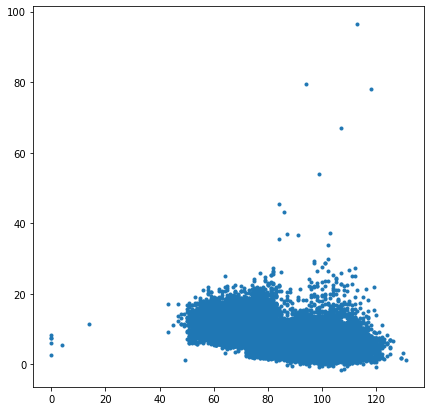

In [303]:
plt.figure(figsize=(7,7))
plt.scatter(df_lag.renewable_lag, df_lag.price_components, marker='.');


6.782024810902515

In [305]:
df_lag['dumb_preds'] = df_lag.price_components.mean()

In [312]:
sMAPE(df_lag.loc['2020','dumb_preds'], df_lag.loc['2020', 'price_components'])

39.24296372435472

In [315]:
np.corrcoef(df_lag.loc['2020','dumb_preds'], df_lag.loc['2020', 'price_components'])[0][1]**2

2.1817948343664437e-32